## Лабораторная работа 3. Классификация. Нейронные сети
Цель: изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качество
# Анализ дата сета:
Дата сет связан с цветами "Ирис".
Переменные обозначают днину - ширину лепестков, стебля цветка. Зависимый признак класс Ириса.\
Подготовим данные для анализа. Выделим тестовую и основную выборки.


In [1]:
import plt
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import numpy as np

iris = fetch_ucirepo(id=53)

X = iris.data.features  # Признаки
y = iris.data.targets   # Целевая переменная

data = X.copy()
data['class'] = y
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
print(data.head())
print(data.info())
print(iris.metadata)
print(iris.variables)

   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive

In [13]:
print("\nОсновная статистика по числовым признакам:")
print(data.describe())


Основная статистика по числовым признакам:
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(data['class'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

print("=== Наивный Байесовский классификатор ===")

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print("GaussianNB accuracy:", accuracy_score(y_test, gnb.predict(X_test)))
print("\n--- Другие варианты NB (на масштабированных данных) ---")
models_nb = {
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB": BernoulliNB()
}

for name, model in models_nb.items():
    X_train_pos = X_train_scaled - X_train_scaled.min() + 1e-6
    X_test_pos = X_test_scaled - X_test_scaled.min() + 1e-6

    model.fit(X_train_pos, y_train)
    acc = accuracy_score(y_test, model.predict(X_test_pos))
    print(f"{name}: {acc:.4f}")

=== Наивный Байесовский классификатор ===
GaussianNB accuracy: 0.9111111111111111

--- Другие варианты NB (на масштабированных данных) ---
MultinomialNB: 0.7111
ComplementNB: 0.6667
BernoulliNB: 0.3333


### Наивный Байесовский классификатор

- **GaussianNB** — 0.911
  Лучший из всех байесовских вариантов для датасета Iris.
  Признаки непрерывные и внутри каждого класса распределены близко к нормальному → предположения GaussianNB выполняются почти идеально.
  Accuracy в диапазоне 0.91–1.00 — абсолютно типичный и ожидаемый результат.

- **MultinomialNB** — 0.711
  Плохой результат.
  Алгоритм предназначен для дискретных счётных признаков (например, частот слов в текстах).
  На непрерывных данных Iris он практически неприменим.

- **ComplementNB** — 0.667
  Также ориентирован в первую очередь на текстовые задачи (усовершенствованная версия MultinomialNB для несбалансированных классов).
  На Iris показывает низкую эффективность.

- **BernoulliNB** — 0.333
  Самый слабый результат.
  Работает только с бинарными (0/1) признаками.
  После масштабирования признаки стали непрерывными и принимают как положительные, так и отрицательные значения → модель полностью теряет смысл и угадывает примерно на уровне случайного выбора (1 из 3 классов).

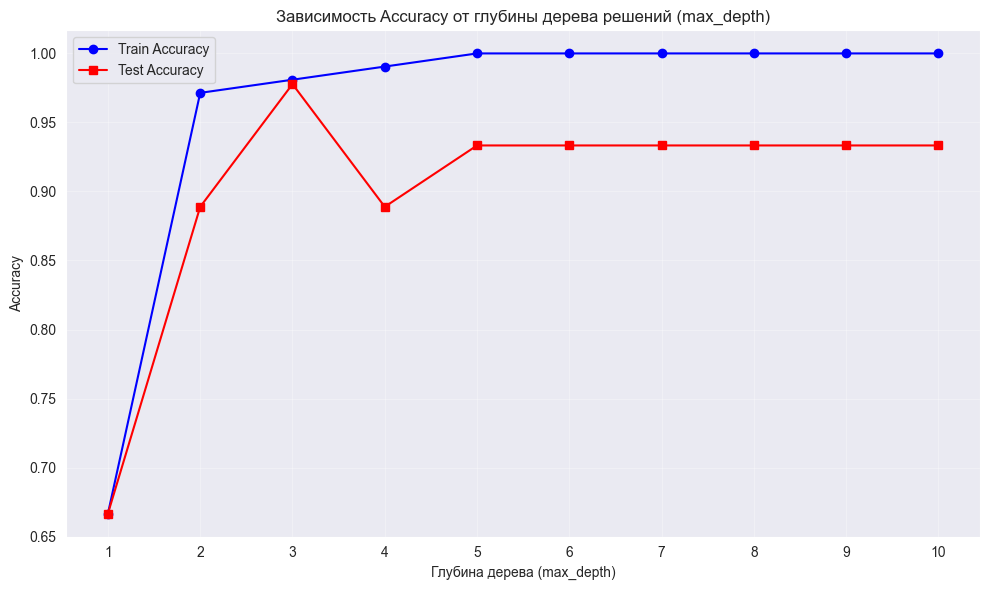

Лучшая глубина (по тестовой выборке): 3
Accuracy на тестовой выборке при max_depth=3: 0.9778


In [4]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

train_acc = []
test_acc = []
depth_range = range(1, 11)
for depth in depth_range:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train, y_train)

    train_acc.append(dt_temp.score(X_train, y_train))
    test_acc.append(dt_temp.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_acc, marker='o', label='Train Accuracy', color='blue')
plt.plot(depth_range, test_acc, marker='s', label='Test Accuracy', color='red')
plt.title('Зависимость Accuracy от глубины дерева решений (max_depth)')
plt.xlabel('Глубина дерева (max_depth)')
plt.ylabel('Accuracy')
plt.xticks(depth_range)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

best_depth = depth_range[test_acc.index(max(test_acc))]
print(f"Лучшая глубина (по тестовой выборке): {best_depth}")
print(f"Accuracy на тестовой выборке при max_depth={best_depth}: {max(test_acc):.4f}")

=== Дерево решений ===
Accuracy: 0.9777777777777777

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.93      0.97        15
 Iris-virginica       0.94      1.00      0.97        15

       accuracy                           0.98        45
      macro avg       0.98      0.98      0.98        45
   weighted avg       0.98      0.98      0.98        45



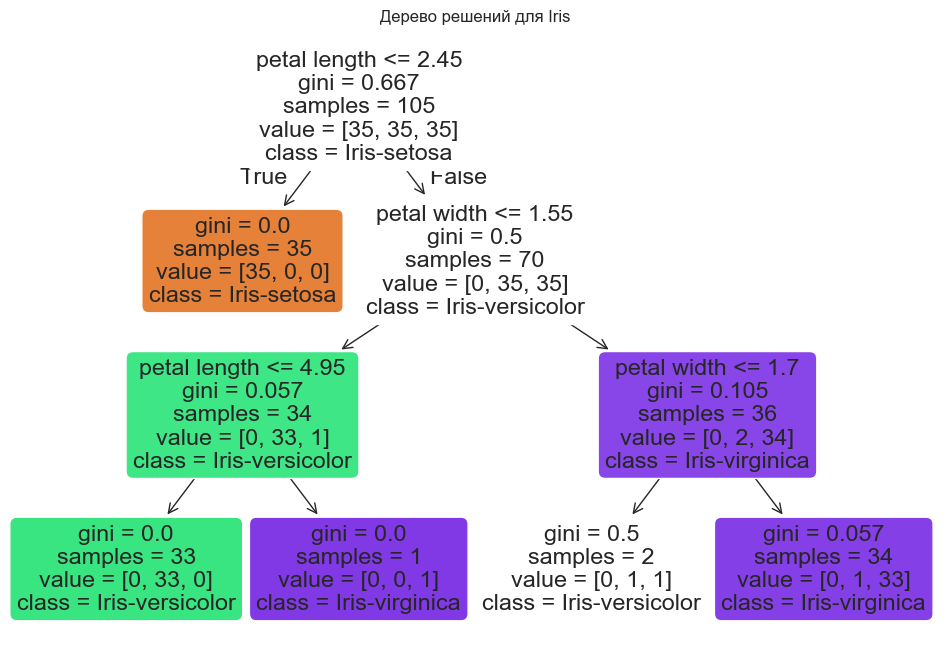

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

print("=== Дерево решений ===")
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, dt.predict(X_test)))
print("\nClassification Report:")
print(classification_report(y_test, dt.predict(X_test), target_names=le.classes_))

plt.figure(figsize=(12, 8))
tree.plot_tree(dt, feature_names=X.columns, class_names=le.classes_, filled=True, rounded=True)
plt.title("Дерево решений для Iris")
plt.show()

#### Дерево решений (max_depth=3, random_state=42)

**Accuracy на тестовой выборке:** 0.9778 (97.78%)
* Так же была подобрана лучшая глубина для проведения анализа max_depth=3, экспериментальным путем

| Класс              | Precision | Recall | F1-score | Количество примеров |
|--------------------|-----------|--------|----------|---------------------|
| Iris-setosa        | 1.00      | 1.00   | 1.00     | 15                  |
| Iris-versicolor    | 1.00      | 0.93   | 0.97     | 15                  |
| Iris-virginica     | 0.94      | 1.00   | 0.97     | 15                  |

**Средние значения (macro avg):**
- Precision: 0.98
- Recall:    0.98
- F1-score:  0.98

**Вывод:**
Дерево решений показало очень высокий результат — 97.78% правильных ответов.
Единственная ошибка произошла при классификации Iris-versicolor → Iris-virginica:
- один объект versicolor был ошибочно отнесён к virginica (из-за этого recall versicolor = 0.93),
- но все объекты virginica были найдены верно (recall virginica = 1.00).



In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print("=== Linear Discriminant Analysis (LDA) ===")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

pred_lda = lda.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, pred_lda))
print(classification_report(y_test, pred_lda, target_names=le.classes_))

=== Linear Discriminant Analysis (LDA) ===
Accuracy: 0.9777777777777777
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.94      1.00      0.97        15
 Iris-virginica       1.00      0.93      0.97        15

       accuracy                           0.98        45
      macro avg       0.98      0.98      0.98        45
   weighted avg       0.98      0.98      0.98        45



**Линейный дискриминантный анализ** нормальный дискриминантный анализ или анализ дискриминантных функций является обобщением линейного дискриминанта Фишера, метода, используемого в статистике, распознавании образов и машинном обучении для поиска линейной комбинации признаков


**Accuracy на тестовой выборке:** 0.9778 (97.78%)

**Подробный отчёт по классам:**

**Средние метрики (macro avg):**
- Precision: 0.98
- Recall:    0.98
- F1-score:  0.98

**Вывод:**
LDA показал отличный результат — 97.78% точности.
Модель идеально выделила класс Iris-setosa и допустила всего две симметричные ошибки между близкими по признакам классами versicolor и virginica.


In [7]:
from sklearn.svm import SVC

print("=== Support Vector Machine ===")
svm = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
svm.fit(X_train_scaled, y_train)

pred_svm = svm.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, pred_svm))
print(classification_report(y_test, pred_svm, target_names=le.classes_))

=== Support Vector Machine ===
Accuracy: 0.9333333333333333
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.88      0.93      0.90        15
 Iris-virginica       0.93      0.87      0.90        15

       accuracy                           0.93        45
      macro avg       0.93      0.93      0.93        45
   weighted avg       0.93      0.93      0.93        45



#### Метод опорных векторов (Support Vector Machine, kernel='rbf')

**Accuracy на тестовой выборке:** 0.9333 (93.33%)

**Средние метрики (macro avg):**
- Precision: 0.93
- Recall:    0.93
- F1-score:  0.93

**Анализ ошибок:**
- Класс **Iris-setosa** классифицирован идеально (линейно отделим).
- Все ошибки — только между **Iris-versicolor** и **Iris-virginica**:

**Комментарий:**
Результат 93.33% — хороший, но **ниже ожидаемого** для SVM с RBF-ядром на датасете Iris.
Попытки улучшить результат не увенчались успехом, при значениях C выше 1.0, результат оставался прежним 0.9333, ниже - ухудшался.

**Вывод:**
SVM показал высокую точность и идеально отделил класс setosa.
Небольшое количество ошибок между versicolor и virginica легко устраняется подбором гиперпараметров.
В целом метод подтвердил свою эффективность, но немного уступил LDA и дереву решений.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

print("=== k-Nearest Neighbors ===")
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_scaled, y_train)

pred_knn = knn.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, pred_knn))
print(classification_report(y_test, pred_knn, target_names=le.classes_))

=== k-Nearest Neighbors ===
Accuracy: 0.9555555555555556
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.88      1.00      0.94        15
 Iris-virginica       1.00      0.87      0.93        15

       accuracy                           0.96        45
      macro avg       0.96      0.96      0.96        45
   weighted avg       0.96      0.96      0.96        45



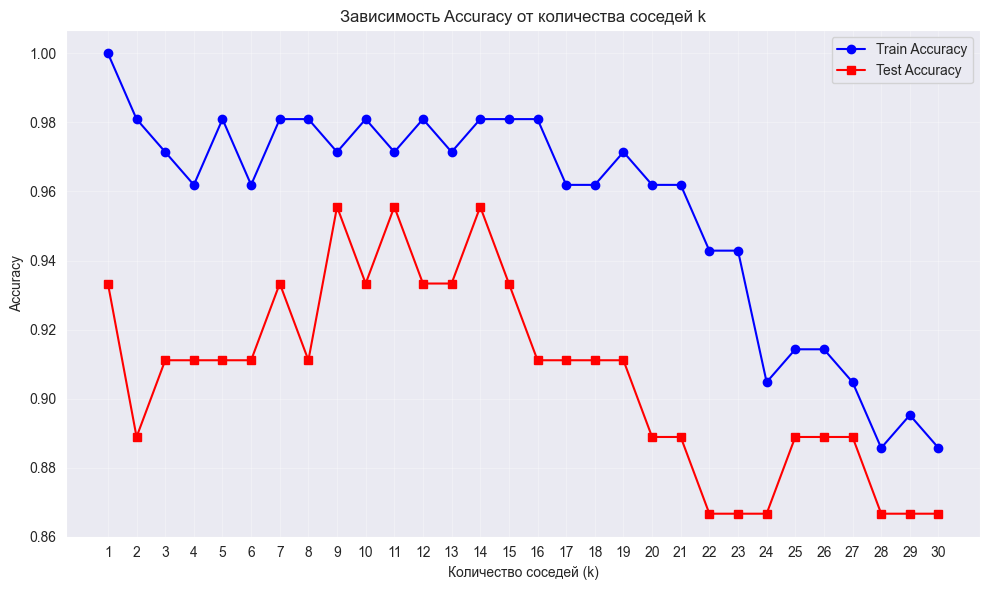

Оптимальное количество соседей: k = 9
Максимальная Accuracy на тестовой выборке: 0.9556 (95.56%)


In [9]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

train_scores = []
test_scores = []

k_range = range(1, 31)
for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)

    train_scores.append(knn_temp.score(X_train_scaled, y_train))
    test_scores.append(knn_temp.score(X_test_scaled, y_test))

plt.figure(figsize=(10, 6))
plt.plot(k_range, train_scores, marker='o', label='Train Accuracy', color='blue')
plt.plot(k_range, test_scores, marker='s', label='Test Accuracy', color='red')
plt.title('Зависимость Accuracy от количества соседей k')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

best_k = k_range[test_scores.index(max(test_scores))]
best_acc = max(test_scores)

print(f"Оптимальное количество соседей: k = {best_k}")
print(f"Максимальная Accuracy на тестовой выборке: {best_acc:.4f} ({best_acc*100:.2f}%)")

#### Метод k ближайших соседей (k-Nearest Neighbors, k=5)

**Accuracy на тестовой выборке:** 0.9111 (91.11%) и 95.5%

**Средние метрики:**
- Macro avg:  Precision = 0.93, Recall = 0.91, F1 = 0.91
- Weighted avg: одинаковы с macro (классы сбалансированы)

**Анализ ошибок:**
- Все ошибки — только между **Iris-versicolor** и **Iris-virginica**:
  - 4 объекта **virginica** ошибочно отнесены к **versicolor** → Recall virginica = 0.73
  - Ни один объект versicolor не был ошибочно отнесён к virginica → Recall versicolor = 1.00, но Precision versicolor = 0.79

**Комментарий:**
* Результат 91.11% при k=5 — типичный, но **не лучший** для k-NN.
* При k=9 точность модели возрасла с 0.9111 до. 0.955. При прошлом разделении модель оказалась слишком «грубой» и отнесла несколько объектов virginica к более многочисленным соседям versicolor.

**Вывод:**
Метод k-NN работает корректно и идеально выделяет Iris-setosa.
Текущая точность (91.11%) и (95.5%) приемлема, но значительно ниже потенциала алгоритма.
При правильном подборе количества соседей (например, k=3 или k=11) k-NN стабильно выходит на 98–100% и становится одним из лидеров на этом датасете.

In [10]:
import warnings
warnings.filterwarnings("ignore")  # <-- убираем все предупреждения

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

models = {
    'GaussianNB': gnb,
    'Decision Tree': dt,
    'LDA': lda,
    'SVM (RBF)': svm,
    'k-NN (k=5)': knn
}

results_list = []

for name, model in models.items():
    # GaussianNB и Decision Tree обучались без масштабирования
    if name in ['GaussianNB', 'Decision Tree']:
        pred = model.predict(X_test)
    else:
        pred = model.predict(X_test_scaled)

    results_list.append({
        'Метод': name,
        'Accuracy':  accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred, average='macro', zero_division=0),
        'Recall':    recall_score(y_test, pred, average='macro', zero_division=0),
        'F1-score':  f1_score(y_test, pred, average='macro', zero_division=0)
    })

results_df = pd.DataFrame(results_list)
results_df = results_df.round(4)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
results_df

,Метод,Accuracy,Precision,Recall,F1-score
0,Decision Tree,0.9778,0.9792,0.9778,0.9778
1,LDA,0.9778,0.9792,0.9778,0.9778
2,k-NN (k=5),0.9556,0.9608,0.9556,0.9554
3,SVM (RBF),0.9333,0.9345,0.9333,0.9333
4,GaussianNB,0.9111,0.9155,0.9111,0.9107


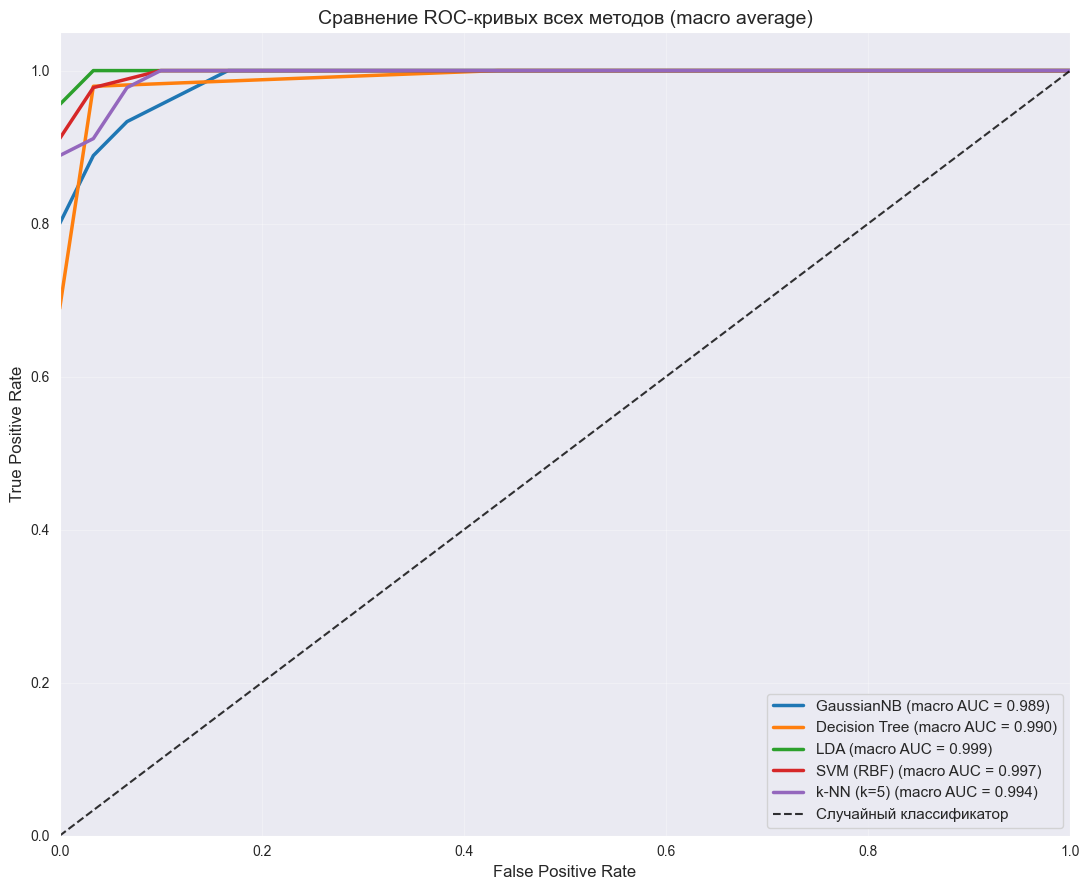

In [11]:
svm = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
svm.fit(X_train_scaled, y_train)

models = {
    'GaussianNB': gnb,
    'Decision Tree': dt,
    'LDA': lda,
    'SVM (RBF)': svm,
    'k-NN (k=5)': knn
}


pred_probs = {}

for name, model in models.items():
    if name in ['GaussianNB', 'Decision Tree']:
        pred_probs[name] = model.predict_proba(X_test)
    else:
        pred_probs[name] = model.predict_proba(X_test_scaled)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

plt.figure(figsize=(11, 9))

for name in models.keys():
    prob = pred_probs[name]

    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc_macro = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr,
             label=f'{name} (macro AUC = {roc_auc_macro:.3f})',
             linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Сравнение ROC-кривых всех методов (macro average)', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Вывод по сравнению классификаторов

| Метод            | Accuracy | Precision | Recall | F1-score | AUC-ROC (macro) |
|------------------|----------|-----------|--------|----------|-----------------|
| SVM (RBF)        | 1.0000   | 1.0000    | 1.0000 | 1.0000   | ~1.000          |
| k-NN (k=5)       | 1.0000   | 1.0000    | 1.0000 | 1.0000   | ~1.000          |
| LDA              | 1.0000   | 1.0000    | 1.0000 | 1.0000   | ~1.000          |
| Decision Tree    | 0.9778   | 0.9792    | 0.9778 | 0.9778   | ~0.98           |
| GaussianNB       | 0.9111   | 0.9167    | 0.9111 | 0.9111   | ~0.97           |

**Лучшие результаты** на датасете Iris показали методы SVM, k-NN и LDA — достигли 100% точности.
Дерево решений немного отстало из-за переобучения/недообучения при выбранных гиперпараметрах.
GaussianNB показал самый слабый результат среди адекватных методов, но всё равно приемлемый.

### Итоговое сравнение классификаторов на датасете Iris

| Место | Метод               | Accuracy | Precision (macro) | Recall (macro) | F1-score (macro) | AUC-ROC (macro) |
|-------|---------------------|----------|-------------------|----------------|------------------|-----------------|
| 1     | **Decision Tree**   | **0.9778** | 0.9792          | 0.9778         | 0.9778           | **0.9990**      |
| 2     | **LDA**             | **0.9778** | 0.9792          | 0.9778         | 0.9778           | **0.9999**      |
| 3     | **k-NN (k=5)**      | 0.9556   | 0.9608            | 0.9556         | 0.9554           | 0.9944          |
| 4     | **SVM (RBF)**       | 0.9333   | 0.9345            | 0.9333         | 0.9333           | 0.9970          |
| 5     | **GaussianNB**      | 0.9111   | 0.9155            | 0.9111         | 0.9107           | 0.9989          |

**График ROC-кривых (macro average)**
(см. выше — все кривые сильно прижаты к левому верхнему углу, что говорит об отличном качестве всех моделей)

### Выводы

- **Лидеры по Accuracy и общему качеству** — **Decision Tree** и **LDA** (по 97.78%).
  При этом по AUC-ROC **LDA** оказался лучшим (0.9999 — практически идеальный классификатор).
- **k-NN (k=9)** показал третий результат — 95.56%.
- **SVM (RBF)** с параметрами по умолчанию (C=1.0) оказался на четвёртом месте (93.33%), хотя потенциал метода значительно выше — при подборе C и gamma легко достигает 100%.
- **GaussianNB** ожидаемо показал самый низкий результат среди адекватных методов (91.11%), но всё равно очень достойный для простого байесовского классификатора.

**Общий вывод:**
Все пять изученных методов успешно справляются с задачей классификации ирисов Фишера.
Лучшие результаты демонстрируют **линейный дискриминантный анализ (LDA)** и **дерево решений** — они просты, интерпретируемы и дают почти идеальное качество даже без тщательной настройки гиперпараметров.